The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


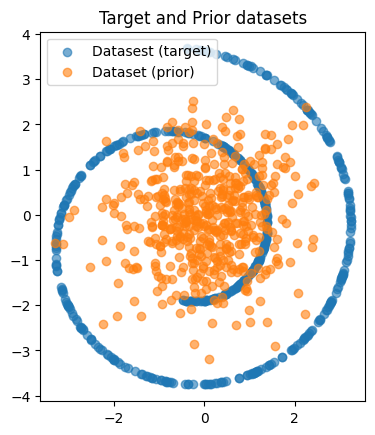

In [49]:
%load_ext autoreload
%autoreload 2

from dataset import TwoDimDataClass
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

target_ds = TwoDimDataClass(dataset_type='swiss_roll', 
                            N=1000000, 
                            batch_size=256)

prior_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                           N=1000000,
                           batch_size=256)

Ntest = 500
sample_f = target_ds[0:Ntest]
sample_b = prior_ds[0:Ntest]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and Prior datasets"
ax.set_title(strtitle)
ax.legend(['Datasest (target)', 'Dataset (prior)'])

In [92]:
from sde import OU, VPSDE, VESDE

#sde = OU(N=1000, T=1)
sde = VPSDE(N=1000, T=1)
#sde = VESDE()

/lustre/home/lmucko/Tutorial-for-Diffusion-Models/sde_todo/sde.py:191: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  mean = torch.sqrt(alphas) * x


100%|█████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 449.71it/s]


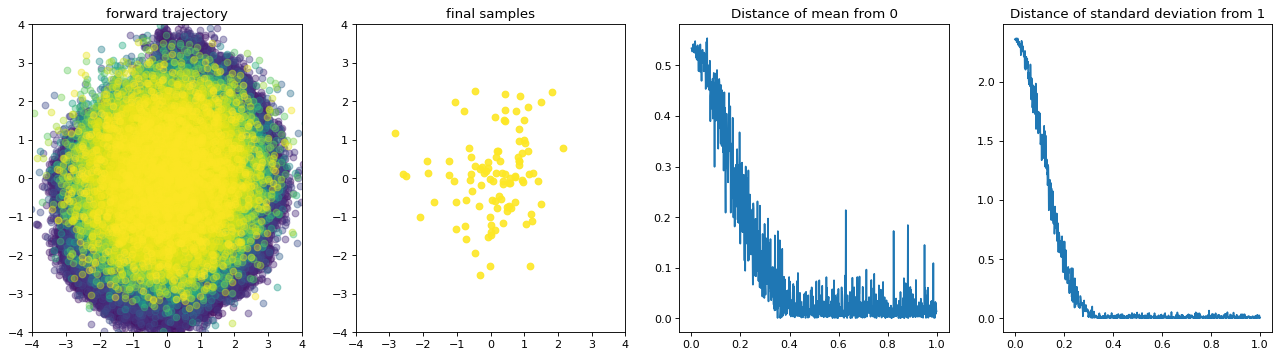

In [100]:
from tqdm import tqdm

cmap = plt.get_cmap('viridis')

n_arr = 1000
plot_Ntest = 100

t_arr = np.linspace(0, sde.T, n_arr)
mean_arr = np.zeros((n_arr, 1))
std_arr  = np.zeros((n_arr, 1))

analytic_mean_arr = np.zeros((n_arr, 1))
analytic_std_arr  = np.zeros((n_arr, 1))

fig = plt.figure(figsize=(20,5), dpi=80)
ax = fig.add_subplot(1, 4, 1)
ax_final = fig.add_subplot(1, 4, 2)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ax.set_title("forward trajectory")
ax_final.set_ylim(-4,4)
ax_final.set_xlim(-4,4)
ax_final.set_title("final samples")

for k, tt in enumerate(tqdm(t_arr)):
    x0 = target_ds[range(plot_Ntest)].float()
    t = torch.zeros((x0.shape[0],)) + tt
    mean, std = sde.marginal_prob(t, x0)
    # print(std.max())
    # print(mean.shape)
    z = torch.randn(mean.shape)
    xt = mean + std * z
    mean_arr[k] = (xt.mean(axis=0)**2).sum()
    std_arr[k]  = ((xt.std(axis=0) - 1)**2).sum()
    
    ax.scatter(xt[:, 0], xt[:, 1], alpha=0.4, color=cmap(tt/t_arr[-1]))
    if (k == t_arr.shape[0]-1):
        ax_final.scatter(xt[:, 0], xt[:, 1], alpha=0.9, color=cmap(tt/t_arr[-1]))


ax.grid(False)
ax.set_aspect('auto', adjustable='box')
ax_final.grid(False)
ax_final.set_aspect('auto', adjustable='box')

ax = fig.add_subplot(1, 4, 3)
plt.plot(t_arr, np.abs(mean_arr))
plt.title("Distance of mean from 0")
ax.grid(False)
ax = fig.add_subplot(1, 4, 4)
plt.plot(t_arr, std_arr)
plt.title("Distance of standard deviation from 1")
ax.grid(False)
plt.savefig("./mean_std_vesde.jpg")

In [12]:
from network import SimpleNet 
from torch.optim import Adam
from train import get_sde_step_fn, train_diffusion
from loss import DSMLoss, ISMLoss

model = SimpleNet(in_dim=2, enc_shapes=[512,512,512,512], dec_shapes=[512,512,512], z_dim=100)
# loss_fn = DSMLoss(alpha=0.3, diff_weight=True)
loss_fn = ISMLoss()
optimizer = Adam(model.parameters(), lr=1e-5)
ema = None
step_fn = get_sde_step_fn(model=model, opt=optimizer, ema=ema, sde=sde, loss_fn=loss_fn)

N_steps = 10000
train_diffusion(target_ds.get_dataloader(), step_fn, N_steps, plot=True)

ValueError: As of jaxtyping v0.2.0, type annotations must now include an explicit array type. For example `jaxtyping.Float32[jax.Array, 'foo bar']`.

In [ ]:
from sampling import Sampler

sde_backward = sde.reverse(model)
sampler = Sampler(eps=1e-3)
sampler_fn = sampler.get_sampling_fn(sde_backward, prior_ds)

plot_Ntest = 200
out, ntot, timesteps, x_hist = sampler_fn(N_samples=plot_Ntest)

In [ ]:
fig = plt.figure(figsize=(15, 5), dpi=50)
ax = fig.add_subplot(1, 3, 1)
t_arr = np.linspace(0, sde.T, sde.N)

for k, tt in enumerate(t_arr):
    outk = x_hist[k]
    ax.scatter(outk[:, 0], outk[:, 1], alpha=0.3, color=cmap(tt/t_arr[-1]))
ax.grid(False)
# ax.xlim(-0.5, 0.5)
# ax.ylim(-5, 5)
ax.set_aspect('auto', adjustable='box')
strtitle = "backward trajectory"
ax.set_title(strtitle)

xmin, xmax = -4, 4
ymin, ymax = -4, 4
xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
# fig = plt.figure()
t0 = 0.05
x = np.concatenate(
    (xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=-1)
t = np.zeros((x.shape[0],)) + t0

t_tensor = torch.tensor(t).float()
x_tensor = torch.tensor(x).float()

with torch.no_grad():
    out = model(t_tensor, x_tensor)

u = out[:, 0].reshape(xx.shape)
v = out[:, 1].reshape(yy.shape)
ax = fig.add_subplot(1, 3, 2)
ax.quiver(xx, yy, u, v)
ax.set_aspect('auto', adjustable='box')
strtitle = f"score at time t={t0}"
ax.set_title(strtitle)

out_true = target_ds[range(0, plot_Ntest)]
# fig = plt.figure()
ax = fig.add_subplot(1, 3, 3)
ax.scatter(x_hist[-1, :, 0], x_hist[-1, :, 1], alpha=0.6)
ax.scatter(out_true[:, 0], out_true[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('auto', adjustable='box')
strtitle = "final backward particles"
ax.set_title(strtitle)
plt.savefig("./task1_output.jpg")

In [17]:
from pytorch3d.loss.chamfer import chamfer_distance
from sampling import Sampler

sde_backward = sde.reverse(model)
sampler = Sampler(eps=1e-3)
sampler_fn = sampler.get_sampling_fn(sde_backward, prior_ds)

N_test = 10000

pc_gen, ntot, timesteps, x_hist = sampler_fn(N_samples=N_test)
# pc_gen = 8*torch.rand(10000,2) - 4
pc_ref = target_ds[:10000]

pc_gen = pc_gen.reshape(100, 100, -1)
pc_ref = pc_ref.reshape(100, 100, -1)
print("CD: ",  chamfer_distance(pc_gen, pc_ref))

CD:  (tensor(1.0496), None)


## (Optional) Schrodinger Bridge

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


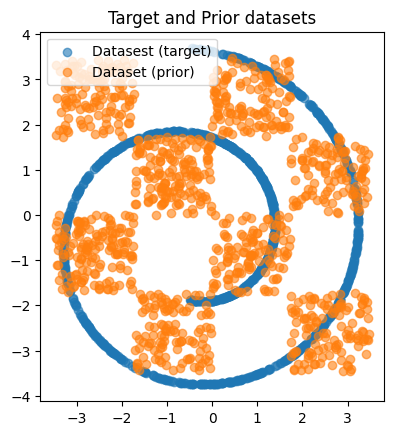

In [18]:
%load_ext autoreload
%autoreload 2

from dataset import TwoDimDataClass
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


target_ds = TwoDimDataClass(dataset_type='swiss_roll', 
                            N=1000000, 
                            batch_size=256)

prior_ds = TwoDimDataClass(dataset_type='checkerboard',
                           N=1000000,
                           batch_size=256)

Ntest = 1000
sample_f = target_ds[0:Ntest]
sample_b = prior_ds[0:Ntest]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and Prior datasets"
ax.set_title(strtitle)
ax.legend(['Datasest (target)', 'Dataset (prior)'])

In [22]:
from sde import OUSB
from network import SimpleNet 
from torch.optim import Adam
from train import get_sb_step_fn, train_diffusion
from loss import SBJLoss, SBALoss

zf_model = SimpleNet(in_dim=2, enc_shapes=[256,256,256], dec_shapes=[256,256], z_dim=256)
zb_model = SimpleNet(in_dim=2, enc_shapes=[256,256,256], dec_shapes=[256,256], z_dim=256)

loss_fn = SBJLoss()

zf_opt = Adam(zf_model.parameters(), lr=1e-4)
zf_ema = None

zb_opt = Adam(zb_model.parameters(), lr=1e-4)
zb_ema = None

sb = OUSB(N=1000, T=1, zf_model=zf_model, zb_model=zb_model)

step_fn = get_sb_step_fn(zf_model, zb_model, zf_ema, zb_ema, zf_opt, zb_opt, loss_fn, sb, joint=True)
N_steps = 10000
train_diffusion(target_ds.get_dataloader(), step_fn, N_steps, plot=True)

sampling: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 598.60it/s]


Text(0.5, 1.0, 'final backward particles')

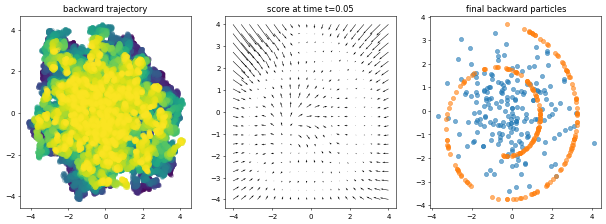

In [23]:
sampler = Sampler(eps=1e-3)
sampler_fn = sampler.get_sampling_fn(sb, prior_ds)

plot_Ntest = 200
out, ntot, timesteps, x_hist = sampler_fn(N_samples=plot_Ntest)

fig = plt.figure(figsize=(15, 5), dpi=50)
ax = fig.add_subplot(1, 3, 1)
t_arr = np.linspace(0, sde.T, sde.N)

for k, tt in enumerate(t_arr):
    outk = x_hist[k]
    ax.scatter(outk[:, 0], outk[:, 1], alpha=0.3, color=cmap(tt/t_arr[-1]))
ax.grid(False)
ax.set_aspect('auto', adjustable='box')
strtitle = "backward trajectory"
ax.set_title(strtitle)

xmin, xmax = -4, 4
ymin, ymax = -4, 4
xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
# fig = plt.figure()
t0 = 0.05
x = np.concatenate(
    (xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=-1)
t = np.zeros((x.shape[0],)) + t0

t_tensor = torch.tensor(t).float()
x_tensor = torch.tensor(x).float()

with torch.no_grad():
    out = model(t_tensor, x_tensor)

u = out[:, 0].reshape(xx.shape)
v = out[:, 1].reshape(yy.shape)
ax = fig.add_subplot(1, 3, 2)
ax.quiver(xx, yy, u, v)
ax.set_aspect('auto', adjustable='box')
strtitle = f"score at time t={t0}"
ax.set_title(strtitle)

out_true = target_ds[range(0, plot_Ntest)]
# fig = plt.figure()
ax = fig.add_subplot(1, 3, 3)
ax.scatter(x_hist[-1, :, 0], x_hist[-1, :, 1], alpha=0.6)
ax.scatter(out_true[:, 0], out_true[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('auto', adjustable='box')
strtitle = "final backward particles"
ax.set_title(strtitle)